[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kyo-takano/chinchilla/blob/master/examples/efficientcube.ipynb)
[![GitHub Repository](https://img.shields.io/badge/-chinchilla-2dba4e?logo=github)](https://github.com/kyo-takano/chinchilla)

> This notebook walks you through how to use `chinchilla` to estimate the scaling law & train compute-optimal models within a budget.
> Takes ~3h using 1 A100 + 12 CPU cores.

---

# **Training Compute-Optimal Rubik's Cube Solvers**

<div>
<img width="480" src="https://raw.githubusercontent.com/kyo-takano/chinchilla/master/docs/imgs/Figure-1.gif" alt="">
</div>

To explore `chinchilla`'s capabilities, we will train over 100 **neural Rubik's Cube solvers**. 
I have chosen this particular task for the following reasons:

- It's easy to train through a simple & stable self-supervised learning task.
- It requires no external data, as the environment itself generates the necessary information.
- It also exhibits the model and data scalability like LLMs.

Please refer to the following work for more details:

> K. Takano. Self-Supervision is All You Need for Solving Rubik's Cube. _Transactions on Machine Learning Research_, ISSN 2835-8856, 2023. URL: https://openreview.net/forum?id=bnBeNFB27b.

## Install `chinchilla`

In [ ]:
!git clone https://github.com/kyo-takano/chinchilla.git
%cd chinchilla
!pip install -e .

/chinchilla
Obtaining file:///chinchilla
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 44.6 MB/s eta 0:00:00
  Building editable for chinchilla (pyproject.toml) ... done
  Created wheel for chinchilla: filename=chinchilla-0.1.0-0.editable-py3-none-any.whl size=2869 sha256=fd3d0e36ceab2cf76a6d153d6dec321f8ba379f8e4370e393102f8008cc1178b
  Stored in directory: /tmp/pip-ephem-wheel-cache-vbgxakan/wheels/5e/44/f9/73f7b8698d143c29bb4b4d8a912812afce921da26ceab88d17
Successfully built chinchilla
  Attempting uninstall: typing-extensio

For the environment to generate training data, let's use the existing code from my repository.

In [ ]:
import os

module_filepath = "efficientcube_env.py"
if not os.path.exists(module_filepath):
    !curl https://raw.githubusercontent.com/kyo-takano/efficientcube/090c320118f96da737a0b161dc956041cfa2a76b/efficientcube/environments.py -o {module_filepath}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18338  100 18338    0     0  42534      0 --:--:-- --:--:-- --:--:-- 42547


## Setup

Libraries & devices

In [ ]:
import numpy as np
import torch
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device, os.cpu_count()

(device(type='cuda'), 12)

### Scalable Model & Grid Search Parameters



Before instantiating a `Chinchilla` class, we need to prepare a few things.

First, let's define the scalable NN class.

In [ ]:
# Modified from https://github.com/kyo-takano/efficientcube/blob/main/efficientcube/model.py
class LinearBlock(nn.Module):
    def __init__(self, input_prev, hidden_size):
        super(LinearBlock, self).__init__()
        self.fc = nn.Linear(input_prev, hidden_size)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(hidden_size)

    def forward(self, inputs):
        x = inputs
        x = self.fc(x)
        x = self.relu(x)
        x = self.bn(x)
        return x


class Net(nn.Module):
    def __init__(self, hidden_size=4096, num_hidden_layers=8, INPUT_DIM=324, OUTPUT_DIM=12):
        super(Net, self).__init__()
        self.INPUT_DIM = INPUT_DIM
        self.embedding = LinearBlock(
            INPUT_DIM, hidden_size
        )  # We don't count embedding as a hidden layer, following the LLM convention
        self.layers = nn.ModuleList([LinearBlock(hidden_size, hidden_size) for i in range(num_hidden_layers)])
        self.output = nn.Linear(hidden_size, OUTPUT_DIM)

    def forward(self, inputs):
        x = nn.functional.one_hot(inputs, num_classes=6).to(torch.float)
        x = x.reshape(-1, self.INPUT_DIM)
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x)
        logits = self.output(x)
        return logits

Second, to get a configuration to initialize `Net` based on $N$ (whether randomly sampled or suggested as compute-optimal), you need to have the following things defined:

1.  A function that arithmetically estimates $N$ from a model configuration
2.  The grid of parameters representing combinations of model configurations to search through

In [ ]:
# 1.
def estimate_model_size(hidden_size, num_hidden_layers, INPUT_DIM=324, OUTPUT_DIM=12):
    # You may narrow down the combinatorial space like this:
    if not 2**6 <= hidden_size / num_hidden_layers < 2**10:
        return float("inf")
    # Assumption: the same hidden_size for all hidden layers
    embedding = (INPUT_DIM + 1) * hidden_size
    layers = num_hidden_layers * ((hidden_size + 1) * hidden_size)
    batchnorms = (num_hidden_layers + 1) * (hidden_size * 2)  # x2 for weight + bias
    logits = (hidden_size + 1) * OUTPUT_DIM
    return sum([embedding, layers, batchnorms, logits])


# 2.
model_search_config = dict(
    size_estimator=estimate_model_size,
    hyperparam_grid=dict(hidden_size=list(range(64, 65536 + 1, 64)), num_hidden_layers=list(range(1, 64))),
)

You can then construct a `Chinchilla` object. In doing so, you have to specify a couple more dictionaries.

- **`seed_ranges`** specifies the regime of seed model allocations as a starter to fit the loss predictor.
- **`param_grid`** specifies a set of initial points to fit the parametric loss predictor with the L-BFGS algorithm

In [ ]:
from chinchilla import Chinchilla


project_dir = "efficientcube-1e15_1e16--mlp"

cc = Chinchilla(
    project_dir,
    seed_ranges=dict(C=(1e15, 1e16), N_to_D=(64, 256)),
    param_grid=dict(
        E=np.linspace(1.0, 1.5, 6),
        a=np.linspace(2, 7, 6),  # Log form (scale doesn't really matter)
        b=np.linspace(2, 7, 6),
        alpha=np.linspace(0.1, 0.5, 5),
        beta=np.linspace(0.1, 0.5, 5),
    ),
    model_search_config=model_search_config,
    scaling_factor=2.0,  # Double the compute budget each step (after seed models)
)

[05:51:36] INFO     Creating a directory: efficientcube-1e15_1e16--mlp                                  ]8;id=874137;file:///chinchilla/chinchilla/core.py\core.py]8;;\:]8;id=535494;file:///chinchilla/chinchilla/core.py#164\164]8;;\

[05:51:36] INFO     Initializing a database to be saved to: efficientcube-1e15_1e16--mlp/df.csv      ]8;id=350968;file:///chinchilla/chinchilla/database.py\database.py]8;;\:]8;id=408541;file:///chinchilla/chinchilla/database.py#61\61]8;;\

[05:51:36] INFO     Chinchilla instance created successfully.                                           ]8;id=155959;file:///chinchilla/chinchilla/core.py\core.py]8;;\:]8;id=147355;file:///chinchilla/chinchilla/core.py#172\172]8;;\

To make sure `seed_ranges` and `model_search_config` are okay, you can use the simulation utility *without scaling steps* to visualize the distribution of random samples.

[05:51:36] INFO     Initializing an in-memory database for Simulator.                                ]8;id=174818;file:///chinchilla/chinchilla/database.py\database.py]8;;\:]8;id=424444;file:///chinchilla/chinchilla/database.py#61\61]8;;\

           INFO     Starting a simulation                                                          ]8;id=806993;file:///chinchilla/chinchilla/simulator.py\simulator.py]8;;\:]8;id=892520;file:///chinchilla/chinchilla/simulator.py#133\133]8;;\

Output()

[05:52:32] WARNING  The scaling law parameters has not been estimated. Plotting only raw data      ]8;id=524273;file:///chinchilla/chinchilla/visualizer.py\visualizer.py]8;;\:]8;id=868010;file:///chinchilla/chinchilla/visualizer.py#96\96]8;;\
                    points.                                                                                        

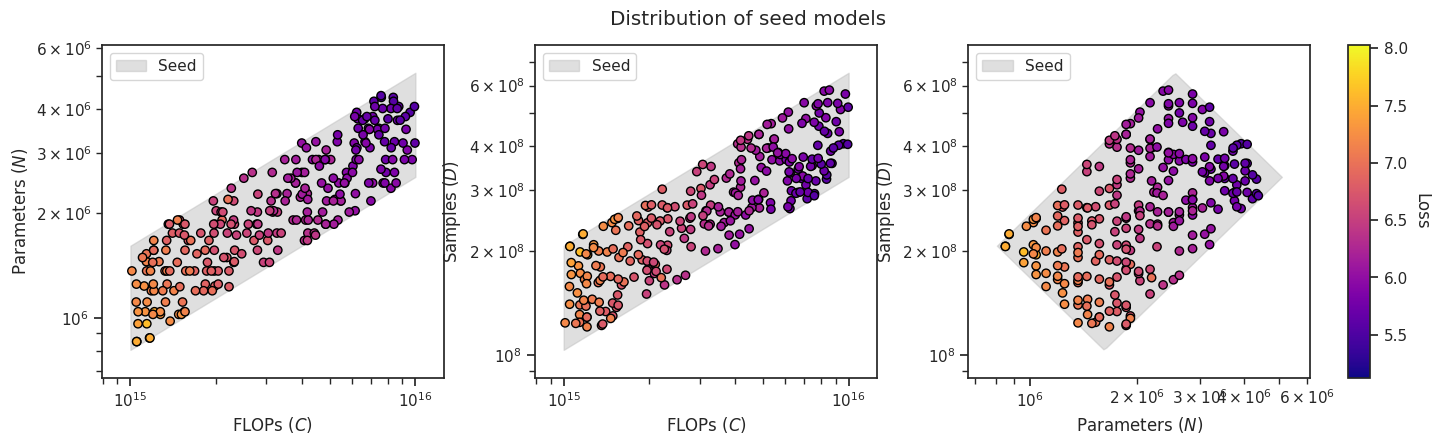

[05:52:34] INFO     Image saved to efficientcube-1e15_1e16--mlp/simulation--raw_data_points.png   ]8;id=241111;file:///chinchilla/chinchilla/visualizer.py\visualizer.py]8;;\:]8;id=295040;file:///chinchilla/chinchilla/visualizer.py#167\167]8;;\

In [ ]:
cc.simulate(256, 0)  # (seeding, scaling)

We can see that they are almost evenly distributed.

### Data

The training data can be generated just by applying the random moves to the goal state.

In [ ]:
from efficientcube_env import Cube3  # From the downloaded code

env = Cube3()


class Dataset(torch.utils.data.Dataset):
    def __init__(self, max_depth=26, num_workers=os.cpu_count()):
        self.num_workers = num_workers
        self.max_depth = max_depth
        self.envs = [Cube3() for _ in range(num_workers)]
        self.generators = [env.scrambler(self.max_depth) for env in self.envs]

    def __len__(self):
        return 0x7FFFFFFF  # max int possible with a single precision

    def __getitem__(self, i):
        "generate one scramble, consisting of `self.max_depth` data points"
        worker_idx = i % self.num_workers
        X = np.zeros((self.max_depth, 6 * 9), dtype=int)
        y = np.zeros((self.max_depth,), dtype=int)
        for j in range(self.max_depth):
            state, last_move = next(self.generators[worker_idx])
            X[j, :] = state
            y[j] = last_move
        return X, y

### Evaluator

As the most important part, you need to have a function or something equivalent to evaluate the allocation $(N,\ D)$.
The most basic way would be just to measure with the objective function.
Alternatively, you may evaluate each trained model on downstream task(s), like [Google did with PaLM 2](https://arxiv.org/abs/2305.10403).
Just make sure that higher performance is signalled as lower values.

In [ ]:
from tqdm import trange
import matplotlib.pyplot as plt


def train_and_evaluate(model, N, D, batch_size=1024, lr=1e-4):
    """
    Train a model and then evaluate the perplexity on the equivalent of 1024 solutions.
    For simplicity, we omit hyperparameter optimization, lr scheduling, etc.
    """
    num_iters = round(D / (batch_size * 26))

    # Set up model, loss function, & optimizer
    model.to(device)
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    # Train
    dl = torch.utils.data.DataLoader(Dataset(), num_workers=os.cpu_count(), batch_size=batch_size)
    g = iter(dl)
    h = []
    for i in trange(num_iters):
        batch_x, batch_y = next(g)
        batch_x, batch_y = batch_x.reshape(-1, 6 * 9).to(device), batch_y.reshape(-1).to(device)
        with torch.cuda.amp.autocast(dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16):
            pred_y = model(batch_x)
            loss = loss_fn(pred_y, batch_y)
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        assert not torch.isnan(loss)
        h.append(loss.item())

    # Evaluate
    model.eval()
    h_test = []
    for i in range(64):
        batch_x, batch_y = next(g)
        batch_x, batch_y = batch_x.reshape(-1, 6 * 9), batch_y.reshape(-1)
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        with torch.no_grad():
            pred_y = model(batch_x)
            loss = loss_fn(pred_y, batch_y)
        h_test.append(loss.detach().cpu().numpy())
    loss = np.mean(h_test)
    assert not np.isnan(loss)

    # Visualize the training result
    plt.plot(h, label="Training")
    plt.axhline(loss, ls=":", color="black", label=f"Test {loss:.4f}")
    plt.xlabel("Steps")
    plt.ylabel("Cross-entropy loss")
    plt.xscale("log")
    plt.legend()
    plt.show()

    return loss

## Estimating the Scaling Law

Now, we first train 100 models at 1 to 10 PetaFLOPs (1e15\~1e16) and then double the compute for 5 consecutive steps.

[07:45:35] INFO        Existing number of seed training runs: 100                                       ]8;id=570283;file:///chinchilla/chinchilla/core.py\core.py]8;;\:]8;id=516977;file:///chinchilla/chinchilla/core.py#488\488]8;;\
                    -> Estimate the parameters (A, B, α, β) from 104 training runs                                 

Output()

[07:47:10] INFO     Goodness-of-fit to Exp(λ=64.64): KS=0.17, p=0.9273610564975882                ]8;id=406804;file:///chinchilla/chinchilla/visualizer.py\visualizer.py]8;;\:]8;id=530285;file:///chinchilla/chinchilla/visualizer.py#225\225]8;;\

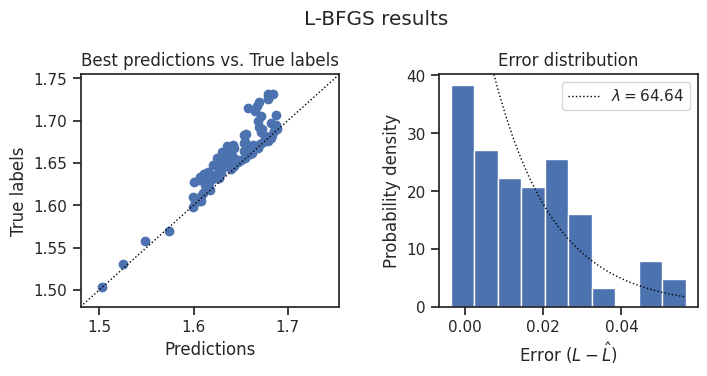

           INFO     Loss predictor:                                                                     ]8;id=442212;file:///chinchilla/chinchilla/core.py\core.py]8;;\:]8;id=104;file:///chinchilla/chinchilla/core.py#383\383]8;;\
                                                                                                                   
                      L(N, D) = 0.7185 + 1.562 / (N ^ 0.07880) + 2.472 / (D ^ 0.09068)                             
                                                                                                                   

[07:47:11] INFO     [105th] 3.27e+17 FLOPs => 2.62e+07 params * 2.08e+09 samples                        ]8;id=973072;file:///chinchilla/chinchilla/core.py\core.py]8;;\:]8;id=904636;file:///chinchilla/chinchilla/core.py#438\438]8;;\

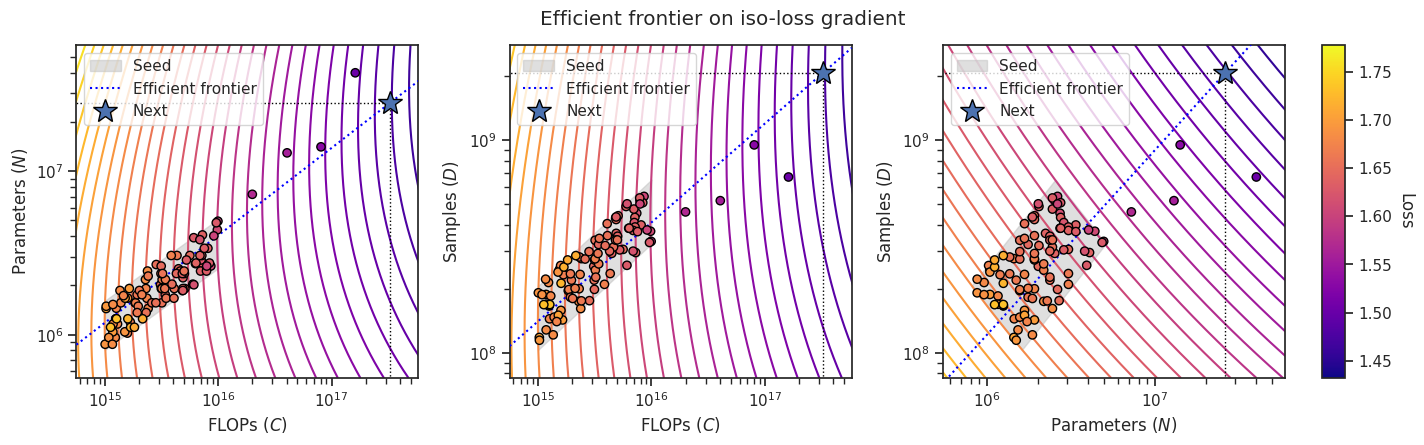

[07:47:13] INFO     Image saved to efficientcube-1e15_1e16--mlp/parametric_fit.png                ]8;id=769910;file:///chinchilla/chinchilla/visualizer.py\visualizer.py]8;;\:]8;id=156920;file:///chinchilla/chinchilla/visualizer.py#167\167]8;;\

model_config={'hidden_size': 1600, 'num_hidden_layers': 10}


100%|██████████| 78081/78081 [58:45<00:00, 22.15it/s]


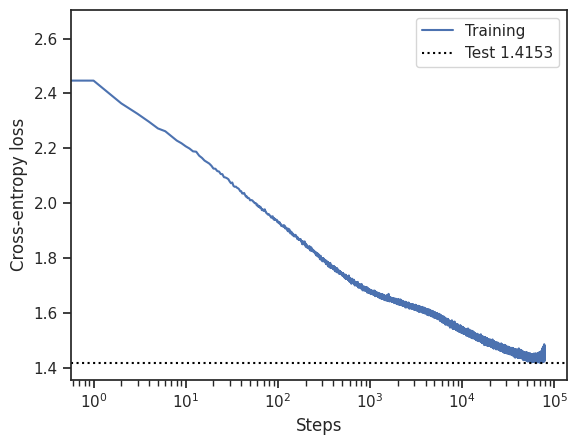

In [ ]:
import gc


for i in range(len(cc.database.df), 105):
    # Sample a new model & update the scaling estimate with more than 100 runs
    (N, D), model_config = cc.step(num_seeding_steps=100)
    """ Internally, something like this is happening:
    >>> if len(cc.database.df) < 100:
    ...     (N, D), model_config = cc.seed()
    ... else:
    ...     cc.fit()
    ...     (N, D), model_config = cc.scale()
    """
    print(f"{model_config=}")

    # Build the model
    model = Net(**model_config)

    # Evaluate the (N, D) scenario by actually training the model
    loss = train_and_evaluate(model, N, D)

    # Record the result
    cc.append(N=N, D=D, loss=loss)

    # Clean the cache
    del model
    gc.collect()
    torch.cuda.empty_cache()

We've now trained a **327 PetaFLOPs** model.

<div>
(Only logs and images for the final model are displayed for aesthetic reasons)
</div>

## Final estimate

Let's fit the loss predictor one last time, and also see the optimal allocation for a **1 ExaFLOP** model (which is totally doable within another 3 hours).

Output()

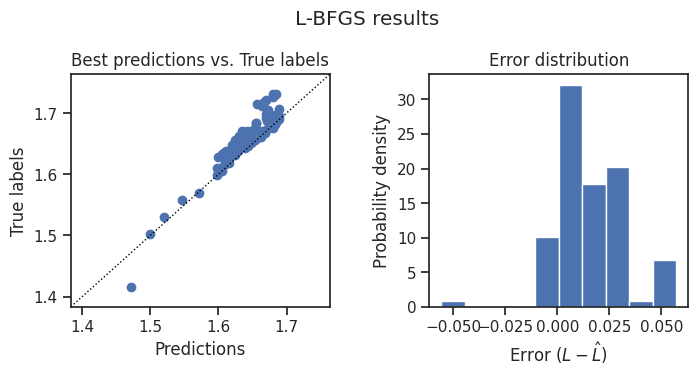

[08:48:46] INFO     Loss predictor:                                                                     ]8;id=142279;file:///chinchilla/chinchilla/core.py\core.py]8;;\:]8;id=545235;file:///chinchilla/chinchilla/core.py#383\383]8;;\
                                                                                                                   
                      L(N, D) = 0.4673 + 1.565 / (N ^ 0.07993) + 2.195 / (D ^ 0.06013)                             
                                                                                                                   

           INFO     [106th] 9.97e+17 FLOPs => 1.69e+07 params * 9.85e+09 samples                        ]8;id=234879;file:///chinchilla/chinchilla/core.py\core.py]8;;\:]8;id=660212;file:///chinchilla/chinchilla/core.py#438\438]8;;\

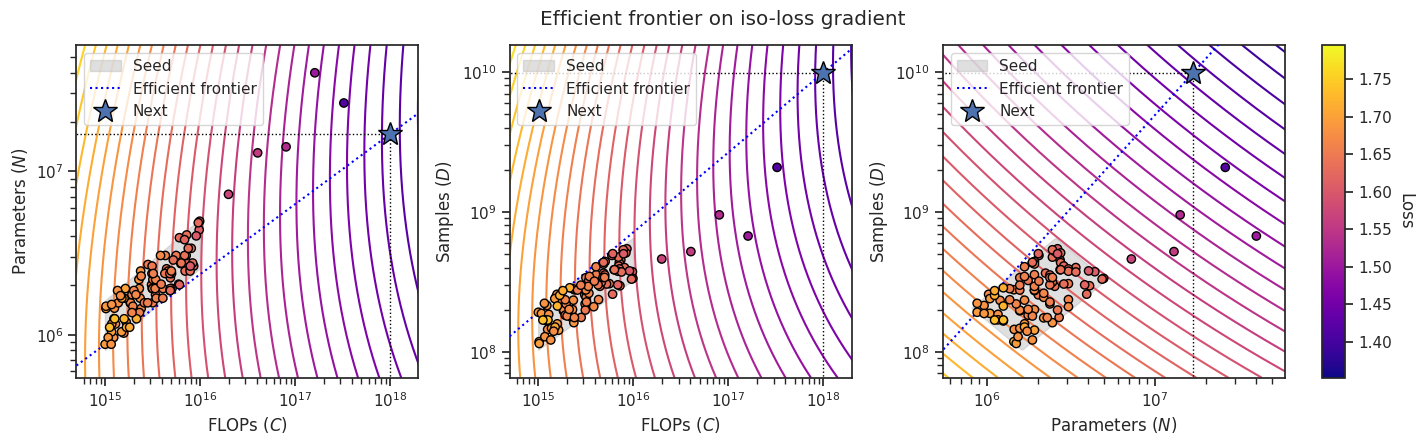

[08:48:48] INFO     Image saved to efficientcube-1e15_1e16--mlp/parametric_fit.png                ]8;id=113449;file:///chinchilla/chinchilla/visualizer.py\visualizer.py]8;;\:]8;id=356135;file:///chinchilla/chinchilla/visualizer.py#167\167]8;;\

In [ ]:
cc.fit()
(N, D), model_config = cc.scale(C=1e18)
# Or `cc.step(C=1e18)` to shortcut

We got to estimate the scaling law parameters, although the final training appears potentially a bit too successful to fit.

You can access more precise values of the estimated parameters like this:

In [ ]:
for param in ["E", "A", "B", "alpha", "beta"]:
    print(f"{param}:\t{getattr(cc, param)}")

E:	0.4673146174310171
A:	1.5649819900429494
B:	2.194778122083905
alpha:	0.07993338519177723
beta:	0.06012628735613125


The balance between `cc.alpha` and `cc.beta` (0.43:0.57) confirms the general scaling law tendency that we should scale parameters and data roughly in tandem

That's it, thanks! 🐭